# State propagation using ODE solver

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse

# Libs and helpers
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.envelopes as envelopes
import c3.libraries.fidelities as fidelities
import c3.libraries.algorithms as algorithms
import c3.utils.tf_utils as tf_utils

2022-08-17 12:37:52.346168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 12:37:52.346208: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Defining the Qubit and the Drive

For this example, lets assume that the $T_1$ and $T_2$ times of the qubit are very small so that we can see the effect of dissipation.

In [2]:
qubit_levels = 4
qubit_frequency = 5e9
qubit_anharm = -200e6
qubit_t1 = 20e-9
qubit_t2star = 40e-9
qubit_temp = 10e-6

qubit = chip.Qubit(
    name="Q",
    desc="Qubit",
    freq=Qty(value=qubit_frequency, min_val=1e9, max_val=8e9, unit="Hz 2pi"),
    anhar=Qty(value=qubit_anharm, min_val=-380e6, max_val=-120e6, unit="Hz 2pi"),
    hilbert_dim=qubit_levels,
    t1=Qty(value=qubit_t1, min_val=1e-9, max_val=90e-3, unit="s"),
    t2star=Qty(value=qubit_t2star, min_val=10e-9, max_val=90e-3, unit="s"),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit="K"),
)

drive_qubit = chip.Drive(
    name="dQ",
    desc="Qubit Drive 1",
    comment="Drive line on qubit",
    connected=["Q"],
    hamiltonian_func=hamiltonians.x_drive,
)

2022-08-17 12:37:55.252081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-17 12:37:55.252127: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 12:37:55.252153: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ashutosh): /proc/driver/nvidia/version does not exist
2022-08-17 12:37:55.252555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Defining the Model

In [3]:
model = Mdl(
    [qubit],  # Individual, self-contained components
    [drive_qubit],  # Interactions between components
)
model.set_lindbladian(True)
model.set_dressed(False)

#### Defining the Generator

RK methods to solve ODE may require a smaller time step for the solutions to converge and match with the results of exponentiation. For this we can increase the simulation resolution to check whether the accuracy of the obtained solutions.

For now we set the simulation resolution `sim_res` to `100e9`, which leads to $\delta t = 10 ps$.

In [4]:
sim_res = 100e9
awg_res = 2e9
v2hz = 1e9

generator = Gnr(
    devices={
        "LO": devices.LO(name="lo", resolution=sim_res, outputs=1),
        "AWG": devices.AWG(name="awg", resolution=awg_res, outputs=1),
        "DigitalToAnalog": devices.DigitalToAnalog(
            name="dac", resolution=sim_res, inputs=1, outputs=1
        ),
        "Response": devices.Response(
            name="resp",
            rise_time=Qty(value=0.3e-9, min_val=0.05e-9, max_val=0.6e-9, unit="s"),
            resolution=sim_res,
            inputs=1,
            outputs=1,
        ),
        "Mixer": devices.Mixer(name="mixer", inputs=2, outputs=1),
        "VoltsToHertz": devices.VoltsToHertz(
            name="v_to_hz",
            V_to_Hz=Qty(value=1e9, min_val=0.9e9, max_val=1.1e9, unit="Hz/V"),
            inputs=1,
            outputs=1,
        ),
    },
    chains={
        "dQ": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        }
    },
)


#### Defining the single qubit gates

In [5]:
t_final = 7e-9
sideband = 50e6
lo_freq = 5e9 + sideband


gauss_params_single = {
    "amp": Qty(value=0.45, min_val=0.35, max_val=0.6, unit="V"),
    "t_final": Qty(
        value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
    ),
    "sigma": Qty(
        value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"
    ),
    "xy_angle": Qty(
        value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
    ),
    "freq_offset": Qty(
        value=-sideband - 0.5e6,
        min_val=-60 * 1e6,
        max_val=-40 * 1e6,
        unit="Hz 2pi",
    ),
    "delta": Qty(value=-1, min_val=-5, max_val=3, unit=""),
}

gauss_env_single = pulse.EnvelopeDrag(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm,
)
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
        )
    },
    shape=envelopes.no_drive,
)
carrier_parameters = {
    "freq": Qty(
        value=lo_freq,
        min_val=4.5e9,
        max_val=6e9,
        unit="Hz 2pi",
    ),
    "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters,
)

rx90p = gates.Instruction(
    name="rx90p", t_start=0.0, t_end=t_final, channels=["dQ"], targets=[0]
)
QId = gates.Instruction(
    name="id", t_start=0.0, t_end=100e-9, channels=["dQ"], targets=[0]
)

rx90p.add_component(gauss_env_single, "dQ")
rx90p.add_component(carr, "dQ")
QId.add_component(nodrive_env, "dQ")
QId.add_component(copy.deepcopy(carr), "dQ")
QId.comps["dQ"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) % (2 * np.pi)
)
ry90p = copy.deepcopy(rx90p)
ry90p.name = "ry90p"
rx90m = copy.deepcopy(rx90p)
rx90m.name = "rx90m"
ry90m = copy.deepcopy(rx90p)
ry90m.name = "ry90m"
ry90p.comps["dQ"]["gauss"].params["xy_angle"].set_value(0.5 * np.pi)
rx90m.comps["dQ"]["gauss"].params["xy_angle"].set_value(np.pi)
ry90m.comps["dQ"]["gauss"].params["xy_angle"].set_value(1.5 * np.pi)

parameter_map = PMap(
    instructions=[QId, rx90p, ry90p, rx90m, ry90m], model=model, generator=generator
)

#### Defining the experiment

In [6]:
# ### MAKE EXPERIMENT
exp = Exp(pmap=parameter_map)
model.set_FR(False)

### Simulating the coherent evolution

In [7]:
model.set_lindbladian(False)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ["rx90p[0]"]

exp.set_opt_gates(sequence)
model.set_init_state(init_state)

compute_states_tf = tf.function(exp.compute_states) # Using tf.function for faster evalution
result = compute_states_tf(solver="rk4")
psis = result["states"]
ts = result["ts"]

Calculating the populations with time - 

In [8]:
pops = []
for psi in psis:
    pop = tf.abs(psi)**2
    pops.append(tf.reshape(pop, pop.shape[:-1]))

##### Plotting the dynamics

/home/ubuntu/miniforge3/envs/PR_state_propagation/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


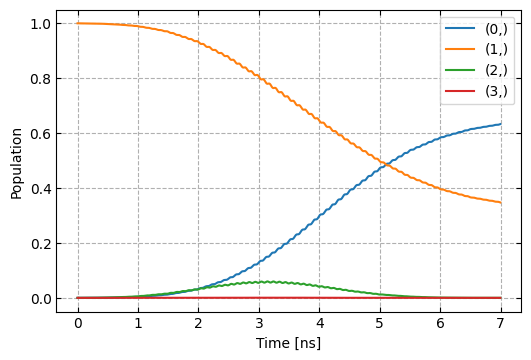

In [9]:
fig, axs = plt.subplots(1, 1)
fig.set_dpi(100)
axs.plot(ts / 1e-9, pops)
axs.grid(linestyle="--")
axs.tick_params(
    direction="in", left=True, right=True, top=True, bottom=True
)
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Population')
plt.legend(model.state_labels)
plt.show()

#### Using a different solver
We can solve the Schrodinger equation by different Runge-Kutta methods. Higher order RK methods are more accurate but may not converge for larger time steps.

Below we use the Tsit5 method to solver the Schrodinger equation.

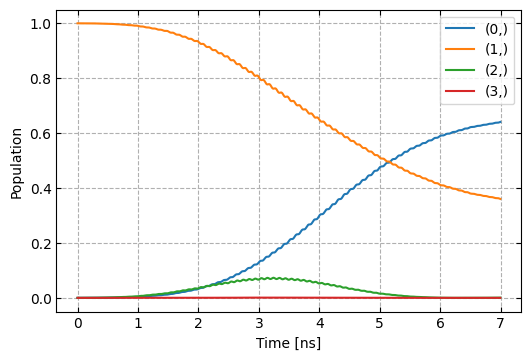

In [10]:
model.set_lindbladian(False)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ["rx90p[0]"]

exp.set_opt_gates(sequence)
model.set_init_state(init_state)

compute_states_tf = tf.function(exp.compute_states) # Using tf.function for faster evalution
result = compute_states_tf(solver="tsit5")
psis = result["states"]
ts = result["ts"]

pops = []
for psi in psis:
    pop = tf.abs(psi)**2
    pops.append(tf.reshape(pop, pop.shape[:-1]))

fig, axs = plt.subplots(1, 1)
fig.set_dpi(100)
axs.plot(ts / 1e-9, pops)
axs.grid(linestyle="--")
axs.tick_params(
    direction="in", left=True, right=True, top=True, bottom=True
)
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Population')
plt.legend(model.state_labels)
plt.show()

### Open-loop optimal control

In [11]:
opt_gates = ["rx90p[0]"]
gateset_opt_map=[
    [
      ("rx90p[0]", "dQ", "gauss", "amp"),
    ],
    [
      ("rx90p[0]", "dQ", "gauss", "freq_offset"),
    ],
    [
      ("rx90p[0]", "dQ", "gauss", "xy_angle"),
    ],
    [
      ("rx90p[0]", "dQ", "gauss", "delta"),
    ],   
    [
      ("rx90p[0]", "dQ", "carrier", "framechange"),
    ]
]
parameter_map.set_opt_map(gateset_opt_map)

In [12]:
parameter_map.print_parameters()

rx90p[0]-dQ-gauss-amp                 : 450.000 mV 
rx90p[0]-dQ-gauss-freq_offset         : -50.500 MHz 2pi 
rx90p[0]-dQ-gauss-xy_angle            : -444.089 arad 
rx90p[0]-dQ-gauss-delta               : -1.000  
rx90p[0]-dQ-carrier-framechange       : 0.000 rad 



Define the target state -

In [13]:
model.set_lindbladian(False)

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1/np.sqrt(2)
index = model.get_state_indeces([(1,)])[0]
psi_init[0][index] = 1/np.sqrt(2)
target_state = tf.transpose(tf.constant(psi_init, tf.complex128))
if model.lindbladian:
    target_state = tf_utils.tf_state_to_dm(target_state)
params = {"target": target_state}

Specifying the Algorithm, fidelity and the parameters for optimization - 
- Now we use the state transfer fidelity (overlap between the inital and target state) as our fidelity measure.
- Here also we can specify the solver and step function for optimization
- Finally, we pass the target state as extra parameter for the fidelity function 

In [14]:
from c3.optimizers.optimalcontrol import OptimalControl
import os
import tempfile

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.state_transfer_from_states,
    fid_subspace=["Q"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 150},
    run_name="better_X90",
    ode_solver="rk4",
    only_final_state=False,
    fid_func_kwargs={"params": params}
)

exp.set_opt_gates(opt_gates)
opt.set_exp(exp)

Optimizing controls - 

In [15]:
opt.optimize_controls()
opt.current_best_goal

C3:STATUS:Saving as: /tmp/tmpcxjguin7/c3logs/better_X90/2022_08_17_T_12_38_24/open_loop.c3log


/home/ubuntu/Ashutosh_files/c3_PR_state_propagation/c3/c3/optimizers/optimizer.py:297: Warning: rx90p[0]-dQ-carrier-framechange has no gradient. This might indicate no usage for current experiment.
  warnings.warn(


0.008304609027849463

#### Plotting dynamics after optimization

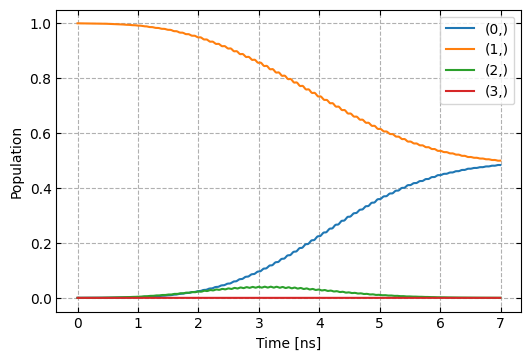

In [17]:
model.set_lindbladian(False)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ["rx90p[0]"]

exp.set_opt_gates(sequence)
model.set_init_state(init_state)

compute_states_tf = tf.function(exp.compute_states) # Using tf.function for faster evalution
result = compute_states_tf(solver="rk4")
psis = result["states"]
ts = result["ts"]

pops = []
for psi in psis:
    pop = tf.abs(psi)**2
    pops.append(tf.reshape(pop, pop.shape[:-1]))

fig, axs = plt.subplots(1, 1)
fig.set_dpi(100)
axs.plot(ts / 1e-9, pops)
axs.grid(linestyle="--")
axs.tick_params(
    direction="in", left=True, right=True, top=True, bottom=True
)
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Population')
plt.legend(model.state_labels)
plt.show()

#### Solving the Master equation
For solving the master equation, we have to set the `model.lindbladian` as `True`.

In [18]:
model.set_lindbladian(True)
psi_init = [[0] * model.tot_dim]
init_state_index = model.get_state_indeces([(1,)])[0]
psi_init[0][init_state_index] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = ["rx90p[0]"]

exp.set_opt_gates(sequence)
model.set_init_state(init_state)

compute_states_tf = tf.function(exp.compute_states) # Using tf.function for faster evalution
result = compute_states_tf(solver="rk4")
psis = result["states"]
ts = result["ts"]

Calculating the populations with time -

In [19]:
pops = []
for rho in psis:
    pops.append(tf.math.real(tf.linalg.diag_part(rho)))

##### Plotting the dynamics

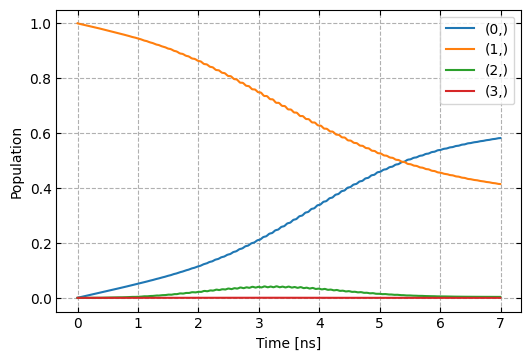

In [20]:
fig, axs = plt.subplots(1, 1)
fig.set_dpi(100)
axs.plot(ts / 1e-9, pops)
axs.grid(linestyle="--")
axs.tick_params(
    direction="in", left=True, right=True, top=True, bottom=True
)
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Population')
plt.legend(model.state_labels)
plt.show()